# Machine Learning - KMeans Clustering

## Import Libraries

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Load Iris Dataset 

In [2]:
df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "uciml/iris", 
        "Iris.csv"    
    )
print("Dataset berhasil dimuat.")
print("Lima data pertama:\n", df.head())
    
X_df = df.drop(['Id', 'Species'], axis=1)
X = X_df.values  
y_species = df['Species']

print(f"\nBentuk matriks fitur X: {X.shape}")
print(f"Nama kolom fitur: {X_df.columns.tolist()}")

Dataset berhasil dimuat.
Lima data pertama:
    Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

Bentuk matriks fitur X: (150, 4)
Nama kolom fitur: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']


## Visualisasi Data Asli

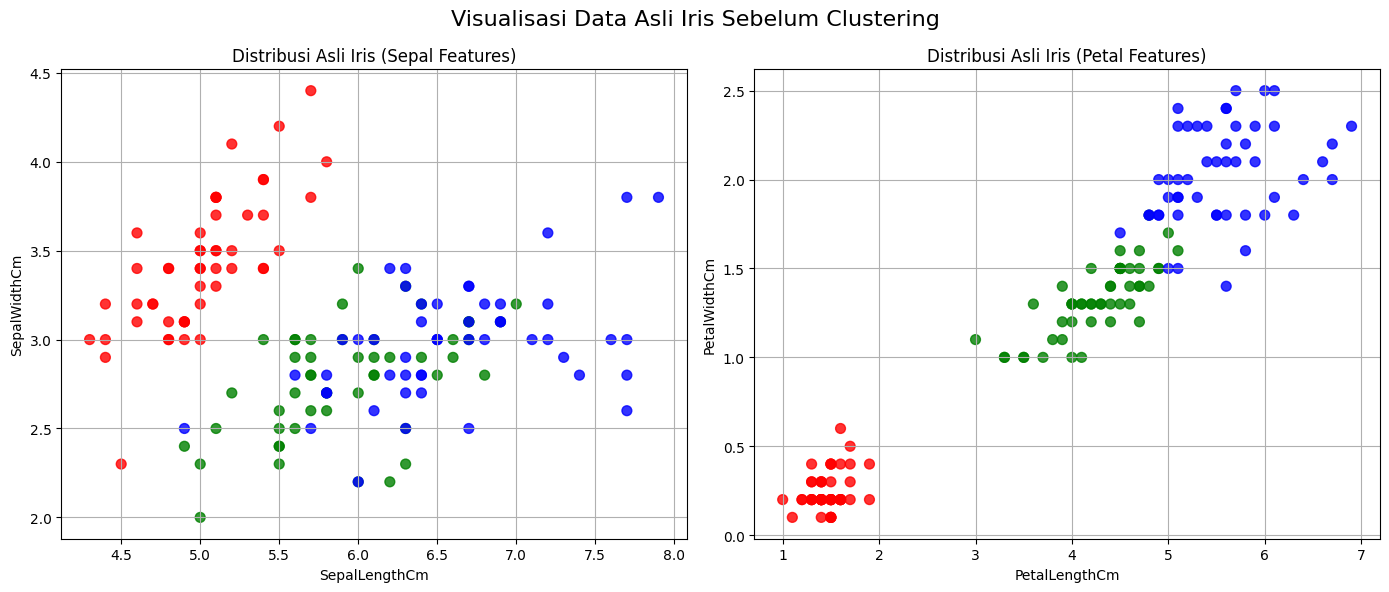

In [3]:
species_to_color = {
    'Iris-setosa': 'red',
    'Iris-versicolor': 'green',
    'Iris-virginica': 'blue'
}
colors = [species_to_color[s] for s in y_species]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.8)
plt.title('Distribusi Asli Iris (Sepal Features)')
plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 2], X[:, 3], c=colors, s=50, alpha=0.8)
plt.title('Distribusi Asli Iris (Petal Features)')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
plt.grid(True)

plt.suptitle('Visualisasi Data Asli Iris Sebelum Clustering', fontsize=16)
plt.tight_layout()
plt.show()

## Fungsi Fungsi K-Means

- Membuat fungsi euclidean_distance untuk menghitung jarak antar titik
- Fungsi initialize_centroids memilih K titik secara acak sebagai centroid awal
- Fungsi assign_to_clusters mengelompokkan titik ke cluster terdekat
- Fungsi update_centroids memperbarui posisi centroid berdasarkan rata-rata cluster
- Fungsi kmeans mengimplementasikan algoritma utama dengan penanganan cluster kosong

In [4]:
def euclidean_distance(point1, point2):
    """Menghitung jarak Euclidean antara dua titik."""
    return np.sqrt(np.sum((point1 - point2)**2))

def initialize_centroids(X, k):
    """Inisialisasi centroid secara acak dari data poin."""
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]
    return centroids

def assign_to_clusters(X, centroids):
    """Menetapkan setiap data poin ke cluster dengan centroid terdekat."""
    clusters = [[] for _ in range(len(centroids))]
    labels = np.zeros(X.shape[0], dtype=int)
    for i, point in enumerate(X):
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        cluster_index = np.argmin(distances)
        clusters[cluster_index].append(point)
        labels[i] = cluster_index
    return clusters, labels

def update_centroids(clusters):
    """Memperbarui centroid berdasarkan rata-rata poin di setiap cluster."""
    new_centroids = []
    for cluster in clusters:
        if cluster: # Pastikan cluster tidak kosong
            new_centroids.append(np.mean(cluster, axis=0))
        else: 
            pass
    return np.array(new_centroids)


def kmeans(X, k, max_iters=100, tol=1e-4):
    """Algoritma K-Means."""
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        old_centroids = centroids
        clusters, labels = assign_to_clusters(X, centroids)

        # Handle empty clusters by re-initializing or keeping old centroids
        new_centroids_list = []
        for i, cluster_points in enumerate(clusters):
            if cluster_points:
                new_centroids_list.append(np.mean(cluster_points, axis=0))
            else:
                # Jika cluster kosong, pertahankan centroid lama untuk cluster tersebut
                # Ini adalah strategi sederhana untuk menangani cluster kosong.
                new_centroids_list.append(old_centroids[i])
        centroids = np.array(new_centroids_list)

        # Periksa konvergensi: Jika centroid tidak banyak berubah, hentikan iterasi
        # Atau jika jumlah centroid berubah
        if old_centroids.shape != centroids.shape or np.sum((centroids - old_centroids)**2) < tol :
            break
    return labels, centroids

## Elbow Method

- Menghitung Within-Cluster Sum of Squares (WCSS) untuk K = 1 hingga 10
- Memplot nilai WCSS terhadap K untuk menemukan "titik siku" (elbow point)
- Titik siku menunjukkan jumlah cluster (K) optimal untuk dataset

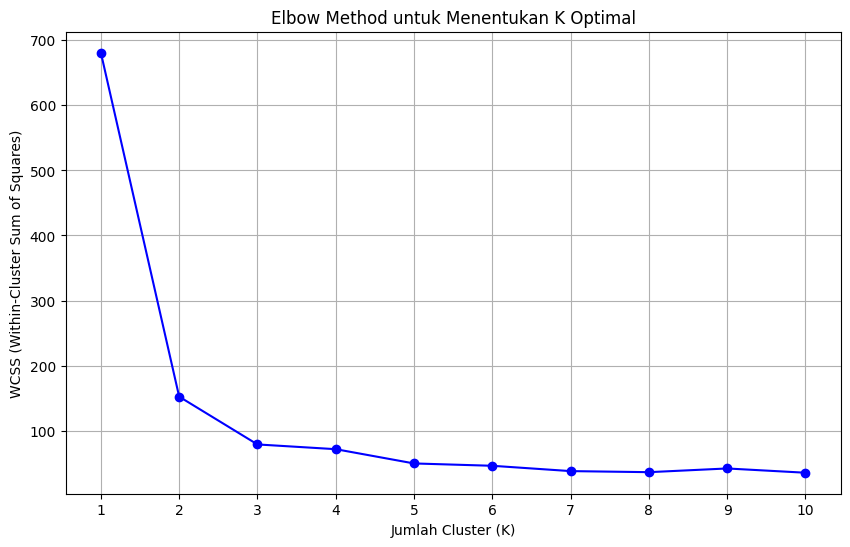

In [5]:
def calculate_wcss(X, labels, centroids):
    """Menghitung Within-Cluster Sum of Squares (WCSS)."""
    # WCSS adalah jumlah kuadrat jarak tiap titik Pi ke pusat kluster
    wcss = 0
    for i, point in enumerate(X):
        # labels[i] = indeks cluster untuk point
        # centroids[labels[i]] = centroid dari cluster tersebut
        wcss += euclidean_distance(point, centroids[labels[i]])**2
    return wcss

wcss_values = []
k_values = range(1, 11) # Coba K 1 - 10

for k_test in k_values:
    labels, centroids = kmeans(X, k_test)
    # Pastikan centroids tidak kosong dan sesuai dengan k_test
    if centroids.shape[0] == k_test : # Hanya hitung WCSS jika jumlah centroid sesuai
        wcss_values.append(calculate_wcss(X, labels, centroids))
    else:
        print(f"Peringatan: Jumlah centroid ({centroids.shape[0]}) tidak sama dengan k ({k_test}). WCSS untuk k ini mungkin tidak akurat.")
        wcss_values.append(np.nan)

# Hapus NaN jika ada sebelum plotting
valid_indices = ~np.isnan(wcss_values)
valid_k_values = np.array(list(k_values))[valid_indices]
valid_wcss_values = np.array(wcss_values)[valid_indices]


plt.figure(figsize=(10, 6))
plt.plot(valid_k_values, valid_wcss_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

## Run K-Means with K-optimal

- Menetapkan K=3
- Menjalankan algoritma K-Means sebanyak 10 kali untuk menemukan hasil terbaik
- Memilih hasil dengan nilai WCSS terendah untuk stabilitas
- Menampilkan posisi centroid optimal yang ditemukan

In [6]:
# Berdasarkan plot Elbow, tentukan K optimal. Disini 3 merupakan titik siku
optimal_k = 3
print(f"Menjalankan K-Means dengan K = {optimal_k}...")

num_runs = 10
best_labels = None
best_centroids = None
lowest_wcss = float('inf')

for run in range(num_runs):
    print(f"Running K-Means iteration {run+1}/{num_runs} for K={optimal_k}")
    labels, centroids = kmeans(X, optimal_k)
    # Pastikan jumlah centroid sesuai dengan optimal_k sebelum menghitung WCSS
    if centroids.shape[0] == optimal_k:
        current_wcss = calculate_wcss(X, labels, centroids)
        if current_wcss < lowest_wcss:
            lowest_wcss = current_wcss
            best_labels = labels
            best_centroids = centroids
    else:
        print(f"  Peringatan di run {run+1}: Jumlah centroid ({centroids.shape[0]}) tidak sama dengan k ({optimal_k}). Run ini diabaikan.")

if best_labels is not None and best_centroids is not None:
    print(f"\nK-Means selesai. WCSS terendah ditemukan: {lowest_wcss:.2f}")
    print("\nCentroid yang ditemukan (untuk K={}):".format(optimal_k))
    for i, centroid in enumerate(best_centroids):
        print(f"Cluster {i+1}: {centroid}")
else:
    print(f"\nK-Means tidak dapat menemukan solusi stabil untuk K={optimal_k} setelah {num_runs} run. Coba lagi atau periksa implementasi.")



Menjalankan K-Means dengan K = 3...
Running K-Means iteration 1/10 for K=3
Running K-Means iteration 2/10 for K=3
Running K-Means iteration 3/10 for K=3
Running K-Means iteration 4/10 for K=3
Running K-Means iteration 5/10 for K=3
Running K-Means iteration 6/10 for K=3
Running K-Means iteration 7/10 for K=3
Running K-Means iteration 8/10 for K=3
Running K-Means iteration 9/10 for K=3
Running K-Means iteration 10/10 for K=3

K-Means selesai. WCSS terendah ditemukan: 78.94

Centroid yang ditemukan (untuk K=3):
Cluster 1: [5.9016129  2.7483871  4.39354839 1.43387097]
Cluster 2: [5.006 3.418 1.464 0.244]
Cluster 3: [6.85       3.07368421 5.74210526 2.07105263]


## Visualisasi Hasil Clustering K-Means 

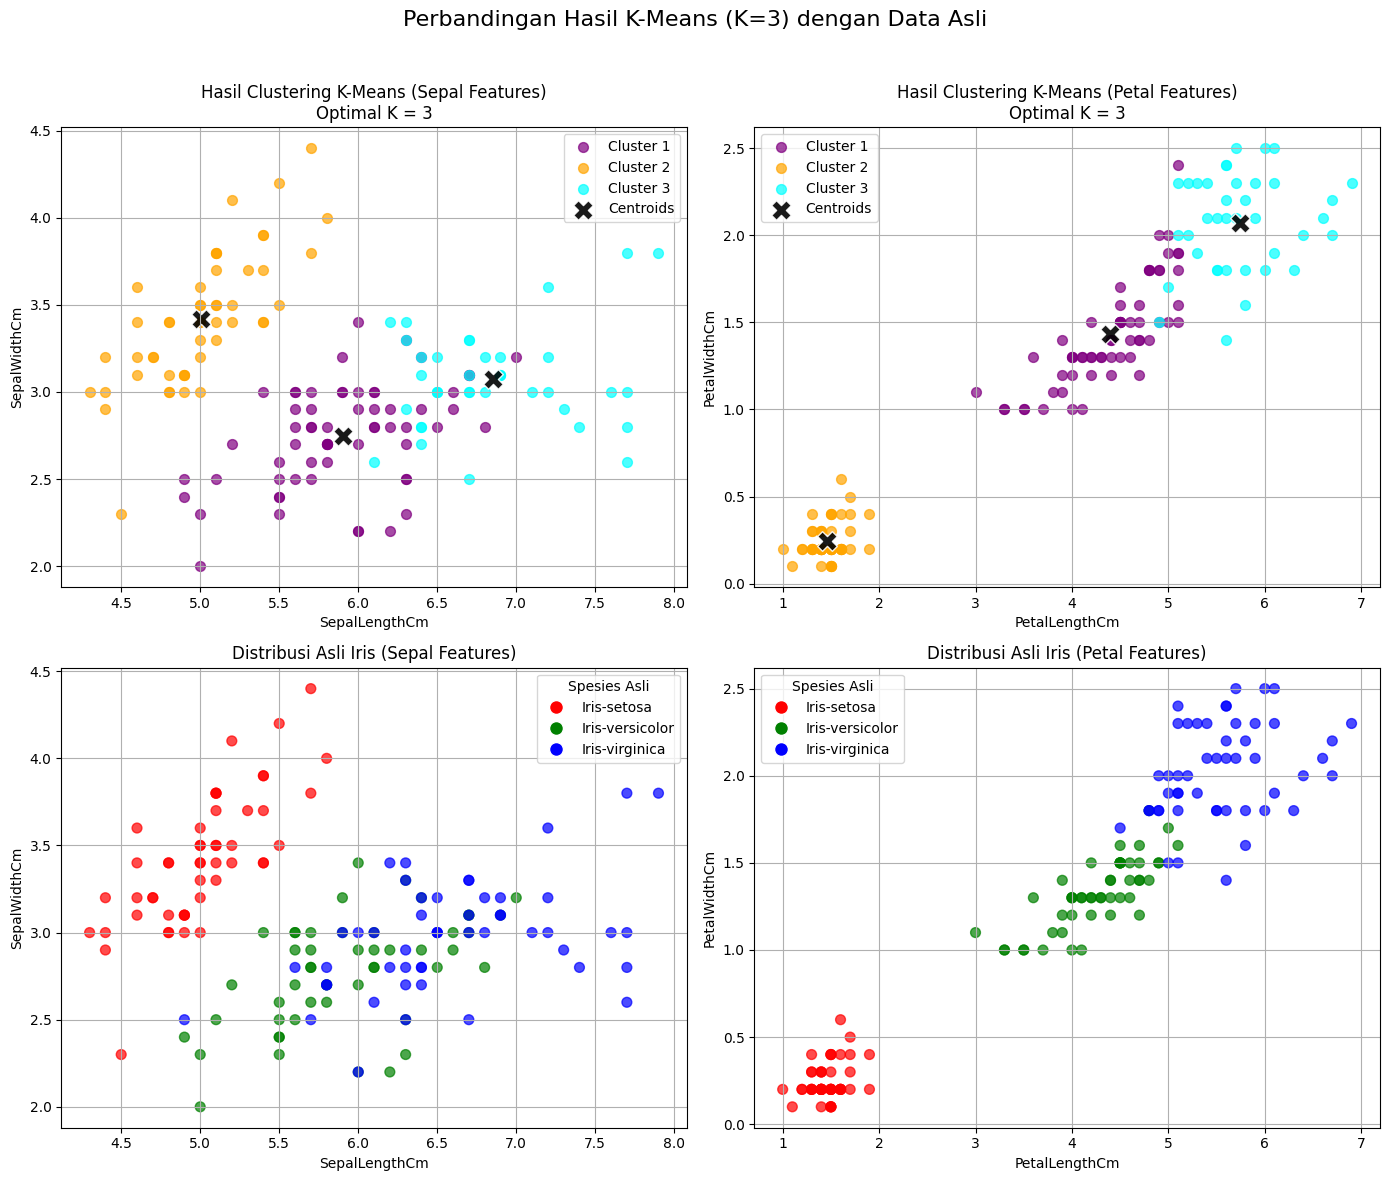

In [7]:
plt.figure(figsize=(14, 12))

kmeans_cluster_colors = ['purple', 'orange', 'cyan', 'blue', 'green', 'red', 'brown']

unique_cluster_labels = np.unique(best_labels)

plt.subplot(2, 2, 1) 
for cluster_label in unique_cluster_labels:
    points_in_cluster = X[best_labels == cluster_label]
    
    color_idx = int(cluster_label)
    if 0 <= color_idx < len(kmeans_cluster_colors):
        point_color = kmeans_cluster_colors[color_idx]
    else:
        point_color = 'gray' 
    plt.scatter(points_in_cluster[:, 0], points_in_cluster[:, 1],
                color=point_color, s=50, label=f'Cluster {cluster_label + 1}', alpha=0.7)

if 'best_centroids' in locals() and best_centroids is not None and best_centroids.shape[0] > 0:
    plt.scatter(best_centroids[:, 0], best_centroids[:, 1], c='black', s=200, marker='X', label='Centroids', alpha=0.9, edgecolors='white') # Changed centroid color for visibility
plt.title(f'Hasil Clustering K-Means (Sepal Features)\nOptimal K = {optimal_k}')
plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2) 
for cluster_label in unique_cluster_labels:
    points_in_cluster = X[best_labels == cluster_label]
    color_idx = int(cluster_label)
    if 0 <= color_idx < len(kmeans_cluster_colors):
        point_color = kmeans_cluster_colors[color_idx]
    else:
        point_color = 'gray'
    plt.scatter(points_in_cluster[:, 2], points_in_cluster[:, 3],
                color=point_color, s=50, label=f'Cluster {cluster_label + 1}', alpha=0.7)

if 'best_centroids' in locals() and best_centroids is not None and best_centroids.shape[0] > 0:
    plt.scatter(best_centroids[:, 2], best_centroids[:, 3], c='black', s=200, marker='X', label='Centroids', alpha=0.9, edgecolors='white') # Changed centroid color
plt.title(f'Hasil Clustering K-Means (Petal Features)\nOptimal K = {optimal_k}')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
plt.legend()
plt.grid(True)

# Plot data asli untuk perbandingan 
plt.subplot(2, 2, 3) 
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.7)
    
plt.title('Distribusi Asli Iris (Sepal Features)')
plt.xlabel(X_df.columns[0])
plt.ylabel(X_df.columns[1])
if 'species_to_color' in locals():
    handles_original = [plt.Line2D([0], [0], marker='o', color='w', label=species,
                              markerfacecolor=color, markersize=10) for species, color in species_to_color.items()]
    plt.legend(title='Spesies Asli', handles=handles_original)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(X[:, 2], X[:, 3], c=colors, s=50, alpha=0.7)

plt.title('Distribusi Asli Iris (Petal Features)')
plt.xlabel(X_df.columns[2])
plt.ylabel(X_df.columns[3])
if 'species_to_color' in locals():
    plt.legend(title='Spesies Asli', handles=handles_original)
plt.grid(True)

plt.suptitle(f'Perbandingan Hasil K-Means (K={optimal_k}) dengan Data Asli', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()